#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import warnings
warnings.simplefilter("ignore")

#Data

(V, Q, Q_r, S_i, dS, TS_i, dTS, N_i, dN, M, DO, i, Sig/TS, Sig, TKN, X, Th, Th_c, Th_n, Th_cn)

In [ ]:
df = pd.read_csv('/content/ASP_Data.csv')
df.head(3)

,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,M,...,Sig,Q,Th_c,Th,dS,dTS,dN,TKN,Thn,Th_cn
0,3132,261,44,309,19,49,11,87,22,2634,...,192,1746.83,9.69,9.17,217,290,38,65,2.2925,11.217412
1,3105,220,37,271,22,44,11,88,23,2649,...,166,1561.05,10.50,9.21,183,249,33,65,2.3025,12.948892
2,2916,207,33,235,21,42,10,79,20,2543,...,140,1481.19,13.41,9.16,174,214,32,59,2.2900,16.777261


In [ ]:
psi_1 = 0.8
psi_2 = 0.2

#C-BOD Removal Regression 1

In [ ]:
df1 = pd.DataFrame()

df1['Y'] = df['V']*df['M']/(2*df['Q']*df['dS']*df['dTS'])
df1['X1'] = 2*df['Q']/(df['Si']*df['Sig']*df['V'])
df1['X2'] = 2*df['i']*df['Q']/(df['Si']*df['Sig']*df['V'])
df1['X3'] = 1/df['Sig']

df1.head(3)

,Y,X1,X2,X3
0,0.028502,0.000034,0.001536,0.005319
1,0.021156,0.000032,0.001613,0.004673
2,0.018713,0.000036,0.001862,0.004717


In [ ]:
df1.corr()

,Y,X1,X2,X3
Y,1.000000,-0.066040,-0.238828,0.622332
X1,-0.066040,1.000000,0.771235,0.638133
X2,-0.238828,0.771235,1.000000,0.398507
X3,0.622332,0.638133,0.398507,1.000000


In [ ]:
Y1 = df1['Y']
X1 = df1.drop(['Y'], axis = 1)

In [ ]:
LR1 = LinearRegression(fit_intercept = False)
LR1.fit(X1, Y1)

LinearRegression(fit_intercept=False)

###Equation

In [ ]:
coeff = LR1.coef_
coeff
c1 = coeff[0]
c2 = coeff[1]
c3 = coeff[2]

print(f'y = ({c1:.2e}).x1 + ({c2:.2e}).x2 + ({c3:.2e}).x3')

y = (-3.06e+02).x1 + (-5.29e+00).x2 + (8.47e+00).x3


In [ ]:
y1_pred = LR1.predict(X1)
r21 = r2_score(Y1, y1_pred)
r21

0.6855013534739001

###Constants

In [ ]:
Kic = c1/c2
print(f'Kic = {Kic:.2f}')

Kic = 57.78


In [ ]:
# K_m = psi_1*c1*K_d/c3
# print(f'K_m = {K_m:.2e}')

In [ ]:
k = 1/(psi_1*c3)
print(f'k = {k:.2e}')

k = 1.48e-01


#C-BOD Removal Regression 2

In [ ]:
df2 = pd.DataFrame()

df2['y'] = 1/df['Th_c']
df2['x1'] = 2/(c3*df['Si']*df['Th'])
df2['x2'] = df['i']

df2.head(3)

,y,x1,x2
0,0.124533,0.000107,45
1,0.133511,0.000100,51
2,0.145773,0.000109,52


In [ ]:
y2 = df2['y']
x2 = df2.drop(['y'], axis = 1)

x21 = df2['x1']
x22 = df2['x2']

In [ ]:
df2.corr()

,y,x1,x2
y,1.000000,0.201618,0.217311
x1,0.201618,1.000000,-0.285775
x2,0.217311,-0.285775,1.000000


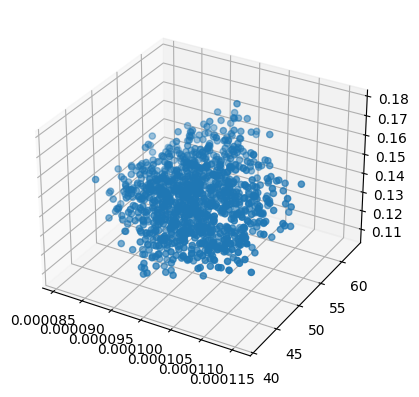

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df2['x1'], df2['x2'], df2['y'])
plt.show()

# plt.figure(figsize = (5, 3))
# plt.scatter(df2['x'], df2['y'])
# plt.show()

In [ ]:
def func2(vars, c21, c22, c23, c24):
  x21, x22 = vars
  return c21/(x21*(c23 + c24*x22) + 1) - c22

In [ ]:
ind_vars = np.vstack((df2['x1'], df2['x2']))
popt2, pcov2 = curve_fit(func2, ind_vars, df2['y'])

c21 = popt2[0]
c22 = popt2[1]
c23 = popt2[2]
c24 = popt2[3]

###Equation

In [ ]:
print(f'({c21:.2e})/(y + ({c22:.2e})) = ({c23:.2e}).x1 + ({c24:.2e}).x1.x2 + 1')

(-5.93e+00)/(y + (-6.01e+00)) = (2.11e+01).x1 + (1.36e+00).x1.x2 + 1


In [ ]:
y2_pred = func2(ind_vars, *popt2)
r22 = r2_score(y2, y2_pred)
r22

0.123356128425125

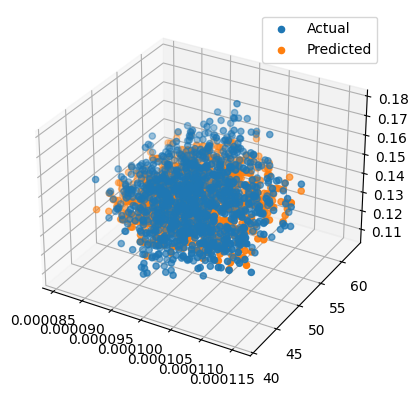

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df2['x1'], df2['x2'], df2['y'], label = "Actual")
axes.scatter(df2['x1'], df2['x2'], func2(ind_vars, c21, c22, c23, c24), label = "Predicted")
plt.legend()
plt.show()

###Constants

In [ ]:
psi_1 = 0.8

In [ ]:
Kd = -c22
print(f'Kd = {Kd:.3f}')

Kd = 6.012


In [ ]:
Mu_max = c21
print(f'Mu_max = {Mu_max:.2e}')

Mu_max = -5.93e+00


In [ ]:
# Km = psi_1*c1*Kd/c3
Km = c23*k*Kd
print(f'Km = {Km:.1f}')

Km = 18.7


###Psi_1 Calc

In [ ]:
df['psi_1'] = np.sqrt(np.abs(2*Km*df['Q']*(1 + df['i']/Kic)/(Kd*df['Si']*df['V']*(1 - Mu_max*df['Th_c']*(1 - Kd*df['Th_c'])))))

df['psi_1'] = df['psi_1'].clip(lower=0, upper=1)
df.head(3)

,Unnamed: 0,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,...,Q,Th_c,Th,dS,dTS,dN,TKN,Thn,Th_cn,psi_1
0,0,13619.2,291,27,307,8,56,9,117,28,...,12718.44,8.03,7.58,264,299,47,89,1.8950,9.490329,0.003977
1,1,13337.6,307,22,348,8,57,8,125,29,...,13858.02,7.49,7.67,285,340,49,96,1.9175,8.540612,0.004508
2,2,13440.0,304,24,346,8,62,10,137,32,...,15507.90,6.86,7.11,280,338,52,105,1.7775,8.592369,0.005242


#NH4-N Removal Regression 1

In [ ]:
df3 = pd.DataFrame()

df3['y'] = df['V']*df['M']/(2*df['Q']*df['dN']*df['dTS'])
df3['x1'] = 2*df['Q']/(df['Ni']*df['Sig']*df['V']*df['DO'])
df3['x2'] = 2*df['Q']*df['i']/(df['Ni']*df['Sig']*df['V']*df['DO'])
df3['x3'] = 2*df['Q']/(df['Ni']*df['Sig']*df['V'])
df3['x4'] = 2*df['Q']*df['i']/(df['Ni']*df['Sig']*df['V'])

df3.head(3)

,y,x1,x2,x3,x4
0,0.160094,0.000058,0.002617,0.000177,0.007983
1,0.123050,0.000049,0.002475,0.000170,0.008688
2,0.100763,0.000050,0.002623,0.000176,0.009130


In [ ]:
y3 = df3['y']
x3 = df3.drop(['y'], axis = 1)

In [ ]:
df3.corr()

,y,x1,x2,x3,x4
y,1.000000,0.297476,0.255374,0.255272,0.132335
x1,0.297476,1.000000,0.894897,0.899418,0.525547
x2,0.255374,0.894897,1.000000,0.993499,0.846018
x3,0.255272,0.899418,0.993499,1.000000,0.840896
x4,0.132335,0.525547,0.846018,0.840896,1.000000


In [ ]:
def func3(vars, alpha, beta, gamma, delta):
  x1, x2, x3, x4 = vars
  return alpha*x1 + beta*x2 + gamma*x3 + delta*x4

In [ ]:
ind_vars = np.vstack((df3['x1'], df3['x2'], df3['x3'], df3['x4']))

popt3, pcov3 = curve_fit(func3, ind_vars, df3['y'])

alpha = popt3[0]
beta = popt3[1]
gamma = popt3[2]
delta = popt3[3]

In [ ]:
y3_pred = func3(ind_vars, *popt3)
r23 = r2_score(y3, y3_pred)
r23

-0.4160939018839547

In [ ]:
Ko = -beta/delta
print(f'Ko = {Ko:.4f}')

Ko = 5.6824


In [ ]:
Knic = gamma/delta
print(f'Knic = {Knic:.2f}')

Knic = -101.57


#NH4-N Removal Regression 2

In [ ]:
df4 = pd.DataFrame()

df4['y'] = 2*(1 + df['i']/Knic)/(df['Th']*(df['Ni']-df['dN']))
df4['x1'] = (df['Th_cn']**2)*(1 + Ko/df['DO'])
df4['x2'] = df['Th_cn']*(1 + Ko/df['DO'])

df4.head(3)

,y,x1,x2
0,0.016328,257.868257,27.171688
1,0.016228,191.029857,22.367234
2,0.013728,194.382566,22.622699


In [ ]:
y4 = df4['y']
x4 = df4.drop(['y'], axis = 1)

In [ ]:
df4.corr()

,y,x1,x2
y,1.000000,-0.162659,-0.051930
x1,-0.162659,1.000000,0.981281
x2,-0.051930,0.981281,1.000000


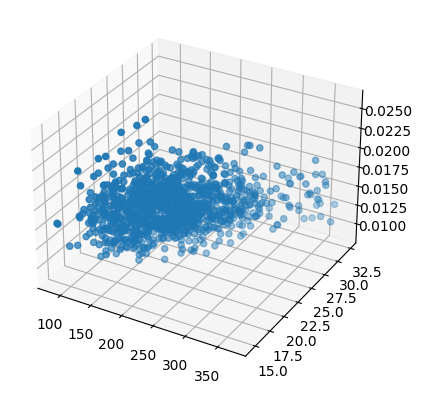

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df4['x1'], df4['x2'], df4['y'])
plt.show()

In [ ]:
# def func4(vars4, c41, c42, c43):
#   x1, x2, x3 = vars4
#   return c41*x1 + c42*x2 + c43*x3

def func4(vars4, c41, c42, c43):
  x1, x2 = vars4
  return c41*x1 + c42*x2 + c43

In [ ]:
# ind_vars4 = np.vstack((df4['x1'], df4['x2'], df4['x3']))
ind_vars4 = np.vstack((df4['x1'], df4['x2']))

popt4, pcov4 = curve_fit(func4, ind_vars4, df4['y'])

c41 = popt4[0]
c42 = popt4[1]
c43 = popt4[2]

popt4

array([-0.00016353,  0.00250633, -0.00972754])

In [ ]:
y4_pred = func4(ind_vars4, *popt4)
r24 = r2_score(y4, y4_pred)
r24

0.3391207302246806

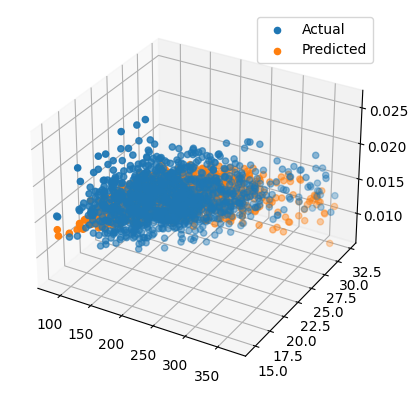

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df4['x1'], df4['x2'], df4['y'], label = "Actual")
axes.scatter(df4['x1'], df4['x2'], func4(ind_vars4, *popt4), label = "Predicted")
plt.legend()
plt.show()

In [ ]:
Kdn = -c41/c42
print(f'Kdn = {Kdn:.4f}')

Kdn = 0.0652


In [ ]:
Mu_nm = c42/c43
print(f'Mu_nm = {Mu_nm:.4f}')

Mu_nm = -0.2577


In [ ]:
psi_2 = 0.2
Knm = -psi_2*Kdn/c43
print(f'Knm = {Knm:.3f}')

Knm = 1.341


In [ ]:
df['psi_2'] = np.abs((2*(Knm/Kdn)*(1 + df['i']/Knic)*df['Q'])/(df['Ni']*df['V']*(Mu_nm*(1 + Ko/df['DO'])*df['Th_cn']*(Kdn*df['Th_cn'] - 1) - 1)))

df['psi_2'] = df['psi_2'].clip(lower=0, upper=1)
df.head(3)

,Unnamed: 0,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,...,Th_c,Th,dS,dTS,dN,TKN,Thn,Th_cn,psi_1,psi_2
0,0,13619.2,291,27,307,8,56,9,117,28,...,8.03,7.58,264,299,47,89,1.8950,9.490329,0.003977,0.229262
1,1,13337.6,307,22,348,8,57,8,125,29,...,7.49,7.67,285,340,49,96,1.9175,8.540612,0.004508,0.240522
2,2,13440.0,304,24,346,8,62,10,137,32,...,6.86,7.11,280,338,52,105,1.7775,8.592369,0.005242,0.239251


#Results

####Psi_1

In [ ]:
psi_1 = df['psi_1'].mean()
psi_1_min = df['psi_1'].min()
psi_1_max = df['psi_1'].max()

print(f'psi_1 :\n Range       : ({psi_1_min:.3f}, {psi_1_max:.3f})')
print(f' Mean Value  : {psi_1:.4f}')

psi_1 :
 Range       : (0.003, 0.006)
 Mean Value  : 0.0046


####Psi_2

In [ ]:
psi_2 = df['psi_2'].mean()
psi_2_min = df['psi_2'].min()
psi_2_max = df['psi_2'].max()

print(f'psi_2 :\n Range       : ({psi_2_min:.4f}, {psi_2_max:.4f})')
print(f' Mean Value  : {psi_2:.4f}')

psi_2 :
 Range       : (0.1565, 0.3611)
 Mean Value  : 0.2193


####Constants

In [ ]:
print(f'Mu_max = {Mu_max:.1f}')
print(f'Mu_nm = {Mu_nm:.2f}\n')
print(f'Kd = {Kd:.3f}')
print(f'Kdn = {Kdn:.3f}\n')
print(f'Km = {Km:.3f}')
print(f'Knic = {Knic:.4f}')

Mu_max = -5.9
Mu_nm = -0.26

Kd = 6.012
Kdn = 0.065

Km = 18.725
Knic = -101.5703
